In [28]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # figure composition
suppressPackageStartupMessages(suppressWarnings(library(cowplot))) # figure composition
suppressPackageStartupMessages(suppressWarnings(library(RcppTOML))) # parsing config file
suppressPackageStartupMessages(suppressWarnings(library(lattice))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(ComplexHeatmap))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(ggplotify))) # grob
suppressPackageStartupMessages(suppressWarnings(library(viridis))) # color
suppressPackageStartupMessages(suppressWarnings(library(platetools))) # make plate plot
suppressPackageStartupMessages(suppressWarnings(library(circlize))) 
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(stringr))) # string manipulation
suppressPackageStartupMessages(suppressWarnings(library(purrr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(VennDiagram))) # venn diagram
suppressPackageStartupMessages(suppressWarnings(library(tidyverse))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggvenn))) # venn diagram
suppressPackageStartupMessages(suppressWarnings(library(grid))) # grid
source("../utils/figure_themes.r")


In [29]:
cell_type <- "PBMC"


In [30]:
montage_image_path = file.path("figures/Montage.png")
montage_image = png::readPNG(montage_image_path)


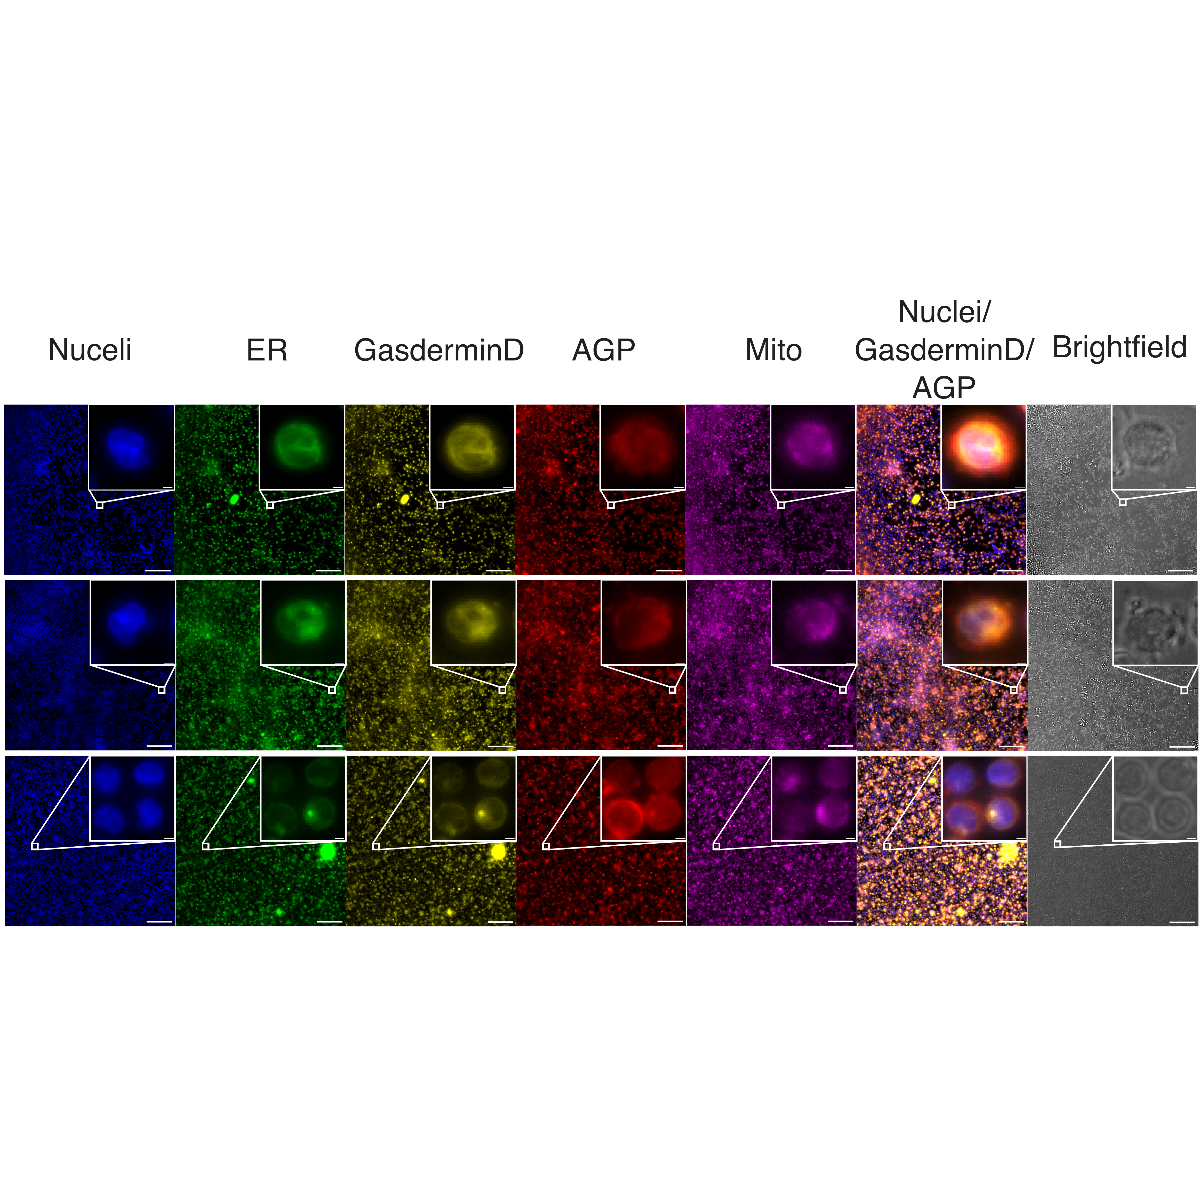

In [31]:
# plot the montage image to a ggplot object
montage <- (
    ggplot()
    + annotation_custom(
        rasterGrob(montage_image, interpolate = TRUE),
        xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf
    )
    + theme_void()
)
montage


In [32]:
# set path to anova results
anova_results_path = file.path(paste0(
    "../../1.Exploratory_Data_Analysis/results/",cell_type,"_combined.parquet"
))
# read in path
anova_results = arrow::read_parquet(anova_results_path)


In [33]:
# create a column that adds group1 and group2 together
anova_results$group = paste0(anova_results$group1,"_",anova_results$group2)
print(nrow(anova_results))
print(ncol(anova_results))


[1] 3753
[1] 12


In [34]:
# filter out rows that have p-adj_abs > 0.05
anova_results = anova_results %>% filter(`p-adj_abs` < 0.05)
print(nrow(anova_results))
print(ncol(anova_results))


[1] 1753
[1] 12


In [36]:
# change the group names to replace healhty with    control
anova_results$group = str_replace_all(anova_results$group,"healthy","control")


In [37]:
# create the three df sets for a venn diagram
a_h <- anova_results %>% filter(group == "apoptosis_control")
a_p <- anova_results %>% filter(group == "apoptosis_pyroptosis")
h_p <- anova_results %>% filter(group == "control_pyroptosis")
a_h <- a_h %>% select(features)
a_p <- a_p %>% select(features)
h_p <- h_p %>% select(features)

# create a list of the three df sets
a_h_list <- a_h %>% pull(features)
a_p_list <- a_p %>% pull(features)
h_p_list <- h_p %>% pull(features)

x=list(a_h_list,a_p_list,h_p_list)


In [38]:
# set plot size 
width <- 10
height <- 10
options(repr.plot.width=width, repr.plot.height=height)
myCol <- brewer.pal(3, "Dark2")
venn_diagram_plot <- venn.diagram(
    x=x,
    show=TRUE,
    category.names = c("Apoptosis \nvs \nControl","Apoptosis \nvs \nPyroptosis","Control \nvs \nPyroptosis"),
    filename = paste0("figures/",cell_type,"_venn_diagram.png"),
    # Output features
    imagetype="png" , 
    resolution = 600,
    compression = "lzw",
    
    # Circles
    lwd = 2,
    lty = 'blank',
    fill = myCol,
    
    # Numbers
    cex = 1,
    fontface = "bold",
    fontfamily = "sans",
    
    # Set names
    cat.cex = 0.8,
    cat.fontface = "bold",
    cat.default.pos = "outer",
    cat.pos = c(-26, 23, 0),
    cat.dist = c(-0.03, -0.03, -0.39),
    cat.fontfamily = "sans",
    rotation = 1

)


In [39]:
# Set the directory path
directory <- "figures"
# List all files in the directory
files <- list.files(directory, full.names = TRUE)
# Filter files that end with ".log"
log_files <- files[grep(".log$", files)]
# Remove the log files
file.remove(log_files)


[1] TRUE

[1] "gg"     "ggplot"

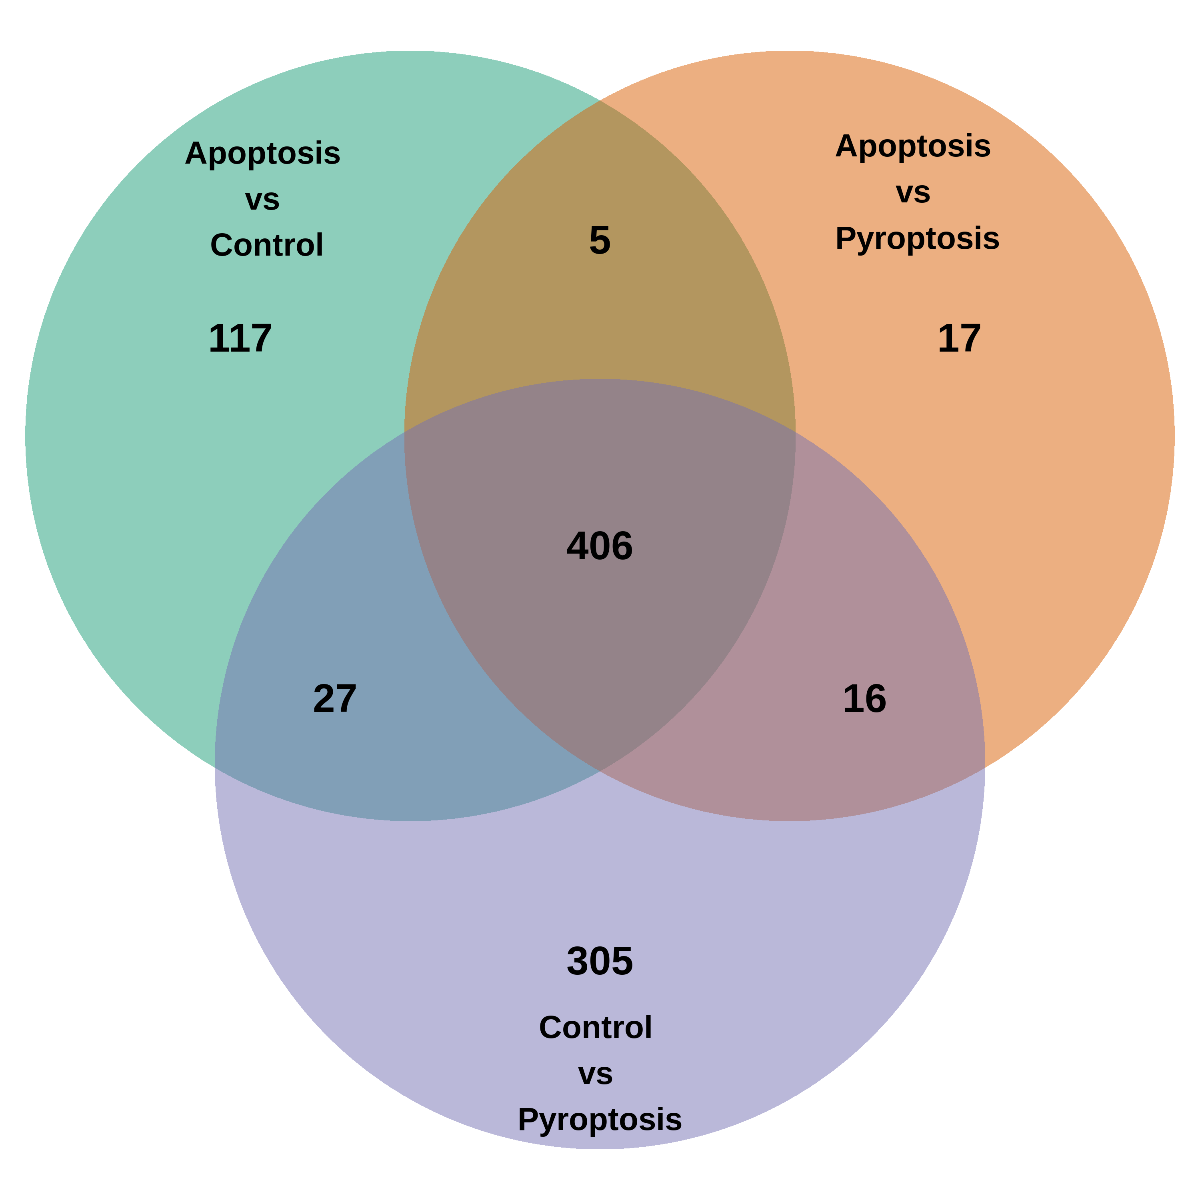

In [40]:
# read in the venn diagram from PNG
venn_diagram_image_path = file.path(paste0("figures/",cell_type,"_venn_diagram.png"))
venn_diagram_image = png::readPNG(venn_diagram_image_path)
# plot the montage image to a ggplot object
venn_diagram_image <- (
    ggplot()
    + annotation_custom(
        rasterGrob(venn_diagram_image, interpolate = TRUE),
        xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf
    )
    + theme_void()
)
# get the type of the object
class(venn_diagram_image)
venn_diagram_image


### Find the unique features for each class 
### Fins the overlapping features between classes

In [54]:
# add sets together
a_h__a_p <- union(a_h_list, a_p_list)
a_h__h_p <- union(a_h_list ,h_p_list)
a_p__h_p <- union(a_p_list ,h_p_list)

# get the unique features for each set
# Apoptosis_vs_Control
# should be 117
a_h_unique <- setdiff(a_h_list, a_p__h_p)
length(a_h_unique)

# Apoptosis_vs_Pyroptosis
# should be 17
a_p_unique <- setdiff(a_p_list, a_h__h_p)
length(a_p_unique)

# Control_vs_Pyroptosis
# should be 305
h_p_unique <- setdiff(h_p_list, a_h__a_p)
length(h_p_unique)


# get the common features for each set
# Apoptosis_vs_Control and Apoptosis_vs_Pyroptosis
# should be 5
a_h__a_p_common <- intersect(a_h_list, a_p_list)
a_h__a_p_common <- setdiff(a_h__a_p_common, h_p_list)
length(a_h__a_p_common)

# Apoptosis_vs_Control and Control_vs_Pyroptosis
# should be 27
a_h__h_p_common <- intersect(a_h_list, h_p_list)
a_h__h_p_common <- setdiff(a_h__h_p_common, a_p_list)
length(a_h__h_p_common)

# Apoptosis_vs_Pyroptosis and Control_vs_Pyroptosis
# should be 16
a_p__h_p_common <- intersect(a_p_list, h_p_list)
a_p__h_p_common <- setdiff(a_p__h_p_common, a_h_list)
length(a_p__h_p_common)

# all three set intersection
# should be 406
a_h__a_p__h_p_common <- intersect(a_h_list, a_p_list)
a_h__a_p__h_p_common <- intersect(a_h__a_p__h_p_common, h_p_list)
length(a_h__a_p__h_p_common)


[1] 117

[1] 17

[1] 305

[1] 5

[1] 27

[1] 16

[1] 406

#### Get df ready for plotting

In [55]:
anova_results_channels <- anova_results %>%
    # dplyr::arrange(desc(abs(group))) %>%
    tidyr::separate(
        features,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel)
    # dplyr::arrange(desc(abs(group)))

# Clean channel for visualization
anova_results_channels$channel_learned <- dplyr::recode(anova_results_channels$channel_cleaned,
        "CorrDNA" = "nuclei",
        "CorrMito" = "Mito",
        "CorrER" = "ER",
        "CorrGasdermin" = "gasdermin",
        "CorrPM" = "PM",
        .default = "other",
        .missing="other"
    )
# rename the values in channel learned
anova_results_channels$channel_learned <- dplyr::recode(anova_results_channels$channel_learned,
        "nuclei" = "Nuclei",
        "Mito" = "Mito",
        "ER" = "ER",
        "gasdermin" = "GasderminD",
        "PM" = "AGP",
        .default = "other",
        .missing="Other"
    )
anova_results_channels$channel_learned <- factor(anova_results_channels$channel_learned, levels = c("Nuclei","Mito","ER","GasderminD","AGP","Other"))


Warning message:
“Expected 6 pieces. Additional pieces discarded in 154 rows [18, 19, 80, 100,
101, 102, 189, 190, 191, 208, 212, 224, 225, 277, 296, 297, 298, 299, 336, 337,
...].”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 429 rows [11, 14, 16, 17,
26, 27, 28, 29, 33, 34, 35, 37, 42, 48, 49, 50, 51, 55, 59, 60, ...].”


In [56]:
# select specfic colors from the color palette
DAPI <- brewer.pal(12,"Paired")[2]
ER <- brewer.pal(12,"Paired")[4]
Gasdermin <- brewer.pal(12,"Paired")[8]
PM <- brewer.pal(12,"Paired")[6]
Mito <- brewer.pal(12,"Paired")[10]
Other <- brewer.pal(8, "Accent")[8]


In [73]:
# set plot size
width <- 10
height <- 10
options(repr.plot.width=width, repr.plot.height=height)
unique_feature_plot_function <- function(df, list_of_unique_features){
    filtered_df <- df %>% filter(features %in% list_of_unique_features)
    # drop duplicate features
    filtered_df <- filtered_df[!duplicated(filtered_df$features),]
    # count the data
    filtered_df_counts <- count(filtered_df, channel_learned)
    # make <NA> vlues in channel_learned Other
    filtered_df_counts$channel_learned <- replace_na(filtered_df_counts$channel_learned, "Other")
    plot <- (
        ggplot(filtered_df_counts, aes(x=channel_learned, y=n, fill=channel_learned))
        + geom_bar(stat = "identity")
        + theme_bw()
        # change colours of bars manually
        + scale_fill_manual(values = c("Nuclei" = DAPI, "Mito" = Mito, "ER" = ER, "GasderminD" = Gasdermin, "AGP" = PM, "Other" = Other))
        + labs(
            x = "Channel",
            y = "Number of Features",
        )
        # legend title change
        
        + guides(fill = guide_legend(title = "Channel"))
        + figure_theme
        # drop the x axis ticks
        + theme(
            axis.text.x = element_blank(),
            axis.ticks.x = element_blank()
        )
        
    )
    plot <- plot + scale_x_discrete(drop = FALSE)
    return(plot)
}

# subset and plot the unique features for each set in the list
# a_h_unique
# a_p_unique
# h_p_unique
# a_h__a_p_common
# a_h__h_p_common
# a_p__h_p_common
# a_h__a_p__h_p_common


a_h_unique_plot <- unique_feature_plot_function(anova_results_channels, a_h_unique)
a_p_unique_plot <- unique_feature_plot_function(anova_results_channels, a_p_unique)
h_p_unique_plot <- unique_feature_plot_function(anova_results_channels, h_p_unique)
a_h__a_p_common_plot <- unique_feature_plot_function(anova_results_channels, a_h__a_p_common)
a_h__h_p_common_plot <- unique_feature_plot_function(anova_results_channels, a_h__h_p_common)
a_p__h_p_common_plot <- unique_feature_plot_function(anova_results_channels, a_p__h_p_common)
a_h__a_p__h_p_common_plot <- unique_feature_plot_function(anova_results_channels, a_h__a_p__h_p_common)

# add titles to each plot
a_h_unique_plot <- a_h_unique_plot + labs(title = "Apoptosis vs Control")
a_p_unique_plot <- a_p_unique_plot + labs(title = "Apoptosis vs Pyroptosis")
h_p_unique_plot <- h_p_unique_plot + labs(title = "Control vs Pyroptosis")
a_h__a_p_common_plot <- a_h__a_p_common_plot + labs(title = "Common Features in Apoptosis vs Control and Apoptosis vs Pyroptosis")
a_h__h_p_common_plot <- a_h__h_p_common_plot + labs(title = "Common Features in Apoptosis vs Control and Control vs Pyroptosis")
a_p__h_p_common_plot <- a_p__h_p_common_plot + labs(title = "Common Features in Apoptosis vs Pyroptosis and Control vs Pyroptosis")
a_h__a_p__h_p_common_plot <- a_h__a_p__h_p_common_plot + labs(title = "Common Features in Apoptosis vs Control, Apoptosis vs Pyroptosis and Control vs Pyroptosis")


In [75]:
cell_umap_path <- file.path(paste0(
    "../","../","1.Exploratory_Data_Analysis/results/",cell_type,"_umap_values_morphology_all_cells.parquet"
))

cell_umap <- arrow::read_parquet(cell_umap_path)
head(cell_umap)


Cytoplasm_AreaShape_Compactness Cytoplasm_AreaShape_Eccentricity
1  0.09913429                     -0.9892539                      
2  0.25248645                      0.8018996                      
3 -1.20653889                     -1.5087519                      
4  1.50801705                      1.4192669                      
5 -0.04922150                     -0.7087415                      
6 -0.17782191                     -0.3350535                      
  Cytoplasm_AreaShape_Extent Cytoplasm_AreaShape_FormFactor
1  1.0469124                 -0.4292652                    
2  0.3428945                 -0.5611980                    
3  1.8451901                  1.8581669                    
4 -0.9139938                 -1.2722049                    
5  0.1227881                 -0.2866189                    
6 -0.1044180                 -0.1489127                    
  Cytoplasm_AreaShape_MajorAxisLength Cytoplasm_AreaShape_MinorAxisLength
1  0.03995555                          1.2751962                         
2  4.32092738                          2.9708813                         
3 -0.90096003                          0.2153558                         
4  3.17484997                         -0.6463060                         
5  0.37476428                          1.5096639                         
6  0.70645323                          1.5723319                         
  Cytoplasm_AreaShape_Orientation Cytoplasm_AreaShape_Zernike_0_0
1  1.3458522                       1.44588602                    
2  0.7841219                      -0.47638729                    
3 -1.2148057                       1.62264544                    
4  0.1083987                      -1.81686393                    
5  0.5787963                       0.40670364                    
6 -0.2771412                      -0.02550445                    
  Cytoplasm_AreaShape_Zernike_1_1 Cytoplasm_AreaShape_Zernike_2_0 ⋯
1 -0.5000572                       1.01968836                     ⋯
2  0.4848230                      -0.03728282                     ⋯
3  0.3772434                       2.08172361                     ⋯
4 -0.5750030                      -1.33666849                     ⋯
5  0.9359895                       0.41471398                     ⋯
6  1.4585851                       0.49466660                     ⋯
  Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_00_256
1  0.4906864                                            
2  0.2848144                                            
3 -0.1037291                                            
4 -1.2353030                                            
5  0.3713184                                            
6  1.8052705                                            
  Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_02_256
1  0.04765855                                           
2  0.20148205                                           
3  0.11071728                                           
4 -0.69339624                                           
5  0.62963223                                           
6  2.16857859                                           
  Nuclei_Texture_SumEntropy_CorrPM_3_01_256
1 -0.3427023                               
2 -0.2615170                               
3  0.5943098                               
4  0.4712619                               
5 -0.3730945                               
6 -2.5171624                               
  Nuclei_Texture_SumVariance_CorrGasdermin_3_01_256
1 -0.06918120                                      
2 -0.02537835                                      
3 -0.06741233                                      
4 -0.03949346                                      
5 -0.04659583                                      
6 -0.06271633                                      
  Nuclei_Texture_SumVariance_CorrMito_3_03_256
1 -0.07433708                                 
2 -0.10781425                                 
3 -0.12600345                                 

In [76]:
# rename the treatment names
cell_umap <- cell_umap %>%
    mutate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% - DMSO 1.0%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 30.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.0%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml - Disulfiram 0.1 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml - Disulfiram 2.5 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_ctr_0.0_0' ~ "Media ctr 0.0 0",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_0.0_0' ~ "Media ctr 0.0 0"
    ))


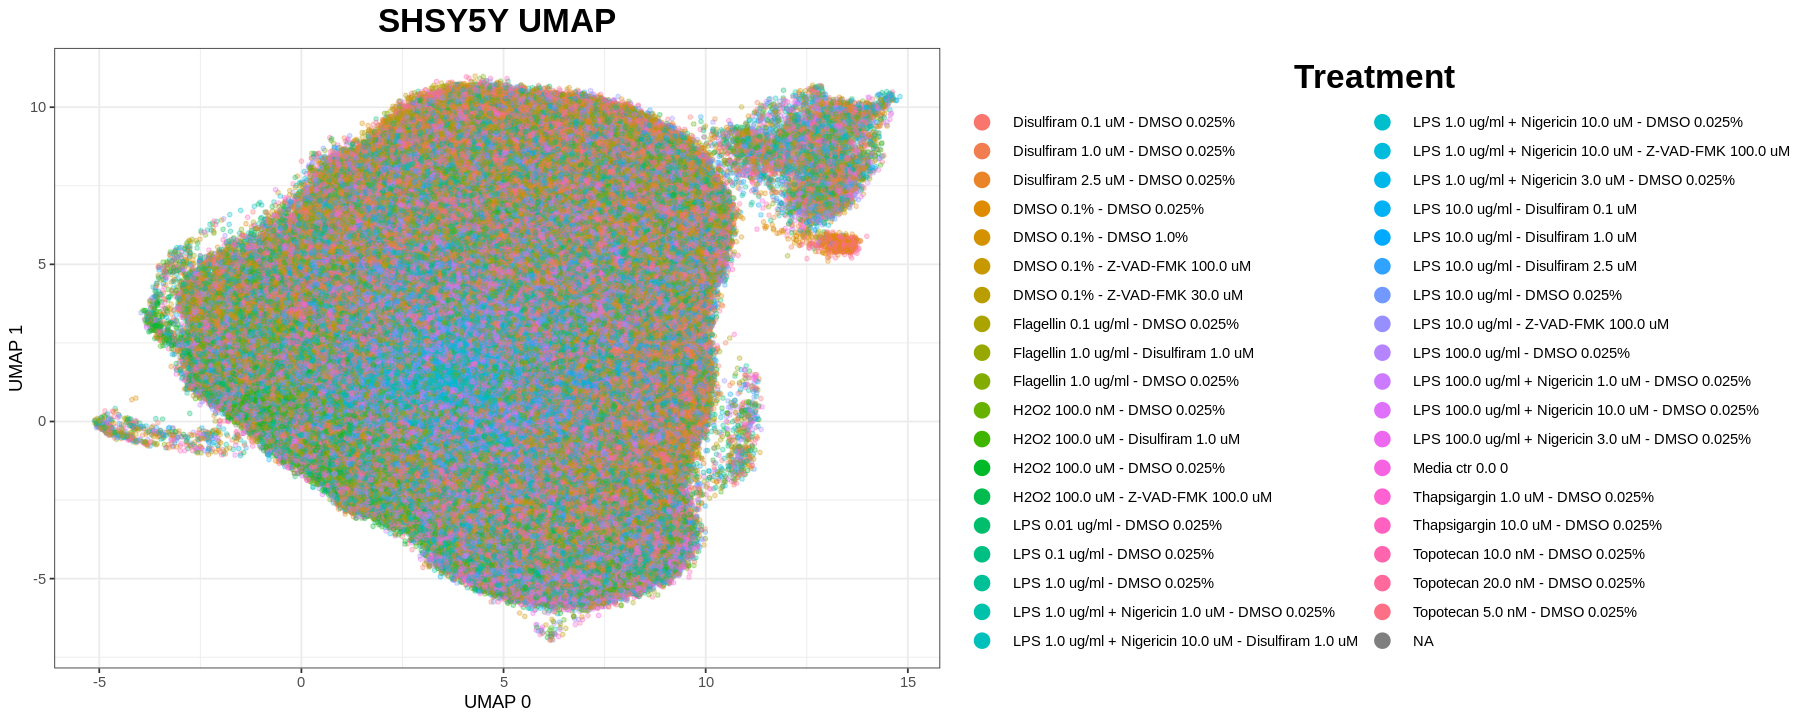

In [77]:
# set plot size 
width <- 15
height <- 6
options(repr.plot.width = width, repr.plot.height = height)
umap_plot_all <- (
    ggplot(cell_umap, aes(x = umap_1, y = umap_2)) 

    + geom_point(
        aes(
            color = oneb_Metadata_Treatment_Dose_Inhibitor_Dose
        ), 
        size = 1, 
        alpha = 0.3
    )
    + theme_bw()
    + guides(
        color = guide_legend(
            override.aes = list(
                size = 4,
                alpha = 1
            )
        )
    )
    + labs(
        x = "UMAP 0",
        y = "UMAP 1",
        color = "Treatment"
    )
    + ggtitle(
        paste0(
            cell_type,
            " UMAP"
        ),
    )
    + theme(
        # change title size
        plot.title = element_text(
            size = 20,
            face = "bold",
            hjust = 0.5
        ),
        legend.title = element_text(
            size = 20,
            face = "bold",
            hjust = 0.5
        ),
    )
)
umap_plot_legend <- get_legend(umap_plot_all)
# umap_plot <- umap_plot + theme(legend.position = "none")
umap_plot_all


In [78]:
# re-read in the cell_umap df
cell_umap_path <- file.path(paste0(
    "../","../","1.Exploratory_Data_Analysis/results/",cell_type,"_umap_values_morphology_all_cells.parquet"
))

cell_umap <- arrow::read_parquet(cell_umap_path)
toml_path <- file.path("..","..","1.Exploratory_Data_Analysis/utils/params.toml")
p <- parseTOML(toml_path)
# get the list that is in the toml file under the key "treatments"
# define that list as a variable called list_of_treatments and print the list to verify
list_of_treatments <- c(p$list_of_treatments$treatments)
# subset the df by the list of treatments
cell_umap_selected_treatments <- cell_umap %>% filter(oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% list_of_treatments)
head(cell_umap_selected_treatments)


Cytoplasm_AreaShape_Compactness Cytoplasm_AreaShape_Eccentricity
1  0.25248645                      0.8018996                      
2  1.50801705                      1.4192669                      
3 -0.64875754                     -0.1010924                      
4 -0.09408633                     -1.4489825                      
5  0.60169295                     -0.3101814                      
6 -0.57698656                     -0.5455632                      
  Cytoplasm_AreaShape_Extent Cytoplasm_AreaShape_FormFactor
1  0.3428945                 -0.5611980                    
2 -0.9139938                 -1.2722049                    
3  1.0401412                  0.5091776                    
4  0.2226912                 -0.2401735                    
5 -0.9934033                 -0.8146829                    
6  0.4111597                  0.3892349                    
  Cytoplasm_AreaShape_MajorAxisLength Cytoplasm_AreaShape_MinorAxisLength
1  4.3209274                           2.9708813                         
2  3.1748500                          -0.6463060                         
3  1.4845037                           2.2152063                         
4 -0.8733283                           0.2303088                         
5 -0.7950074                          -0.2969540                         
6 -0.4161198                           0.3471109                         
  Cytoplasm_AreaShape_Orientation Cytoplasm_AreaShape_Zernike_0_0
1  0.7841219                      -0.4763873                     
2  0.1083987                      -1.8168639                     
3  0.9920135                       1.5537602                     
4 -0.6849343                       0.4832282                     
5 -0.6165520                      -0.4114504                     
6  0.1533789                       1.2112765                     
  Cytoplasm_AreaShape_Zernike_1_1 Cytoplasm_AreaShape_Zernike_2_0 ⋯
1  0.4848230                      -0.03728282                     ⋯
2 -0.5750030                      -1.33666849                     ⋯
3  0.3503180                       0.78766254                     ⋯
4 -0.5045410                      -0.64590847                     ⋯
5 -1.4745887                      -0.10628485                     ⋯
6  0.2126553                       0.20357959                     ⋯
  Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_00_256
1  0.2848144                                            
2 -1.2353030                                            
3  0.3366405                                            
4 -0.0426940                                            
5  0.8244877                                            
6  0.1390677                                            
  Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_02_256
1  0.20148205                                           
2 -0.69339624                                           
3  0.58148103                                           
4  0.06788883                                           
5  1.02957934                                           
6  0.05472007                                           
  Nuclei_Texture_SumEntropy_CorrPM_3_01_256
1 -0.2615170                               
2  0.4712619                               
3  0.2932146                               
4 -0.3333299                               
5 -1.2975443                               
6  0.2846006                               
  Nuclei_Texture_SumVariance_CorrGasdermin_3_01_256
1 -0.02537835                                      
2 -0.03949346                                      
3 -0.04752625                                      
4 -0.06650518                                      
5 -0.06911058                                      
6  0.73144654                                      
  Nuclei_Texture_SumVariance_CorrMito_3_03_256
1 -0.10781425                                 
2  0.18757762                                 
3 -0.03512160                                 

In [79]:


# mutate the names of each treatment
cell_umap_selected_treatments <- cell_umap_selected_treatments %>%
    mutate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "DMSO_0.100_%_DMSO_0.025_%" ~ "DMSO 0.1%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.025_%" ~ "Flagellin 1.0 ug/ml",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM"
    ))

     


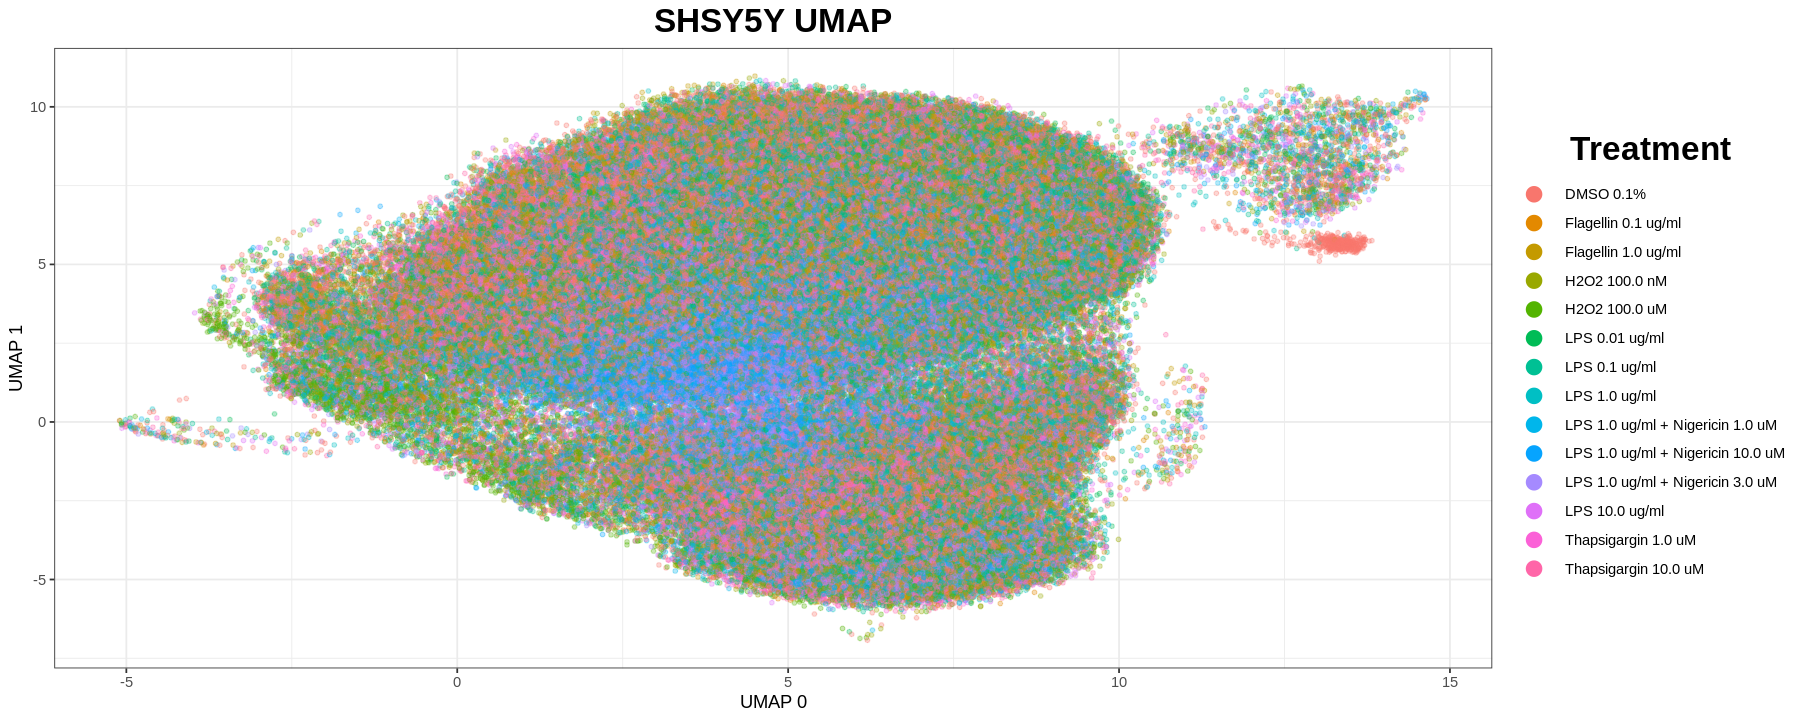

In [80]:
# set plot size 
width <- 15
height <- 6
options(repr.plot.width = width, repr.plot.height = height)
umap_plot_selected <- (
    ggplot(cell_umap_selected_treatments, aes(x = umap_1, y = umap_2)) 

    + geom_point(
        aes(
            color = oneb_Metadata_Treatment_Dose_Inhibitor_Dose
        ), 
        size = 1, 
        alpha = 0.3
    )
    + theme_bw()
    + guides(
        color = guide_legend(
            override.aes = list(
                size = 4,
                alpha = 1
            )
        )
    )
    + labs(
        x = "UMAP 0",
        y = "UMAP 1",
        color = "Treatment"
    )
    + ggtitle(
        paste0(
            cell_type,
            " UMAP"
        ),
    )
    + theme(
        # change title size
        plot.title = element_text(
            size = 20,
            face = "bold",
            hjust = 0.5
        ),
        legend.title = element_text(
            size = 20,
            face = "bold",
            hjust = 0.5
        ),
    )
)
umap_plot_legend <- get_legend(umap_plot_selected)
# umap_plot <- umap_plot + theme(legend.position = "none")
umap_plot_selected


In [81]:
# change bar plot title colours to match the venn diagram

a_h_unique_plot <- a_h_unique_plot + theme(
    plot.title = element_text(
        color=brewer.pal(3, "Dark2")[1], 
        size=14, 
        face="bold", 
        hjust = 0.5
        # remove x axis label

    ),
    axis.title.x = element_blank()
)
a_p_unique_plot <- a_p_unique_plot + theme(
    plot.title = element_text(
        color=brewer.pal(3, "Dark2")[2], 
        size=14, 
        face="bold", 
        hjust = 0.5
        # remove x axis label

    ),
    axis.title.x = element_blank()
)
h_p_unique_plot <- h_p_unique_plot + theme(
    plot.title = element_text(
        color=brewer.pal(3, "Dark2")[3], 
        size=14, 
        face="bold", 
        hjust = 0.5
        # remove x axis label

    ),
    axis.title.x = element_blank()
)
a_h__a_p__h_p_common_plot <- a_h__a_p__h_p_common_plot + ggtitle(
    "All Common Features"
) + theme(
    plot.title = element_text(
        color="black", 
        size=14, 
        face="bold", 
        hjust = 0.5
        # remove x axis label

    ),
    axis.title.x = element_blank()
)


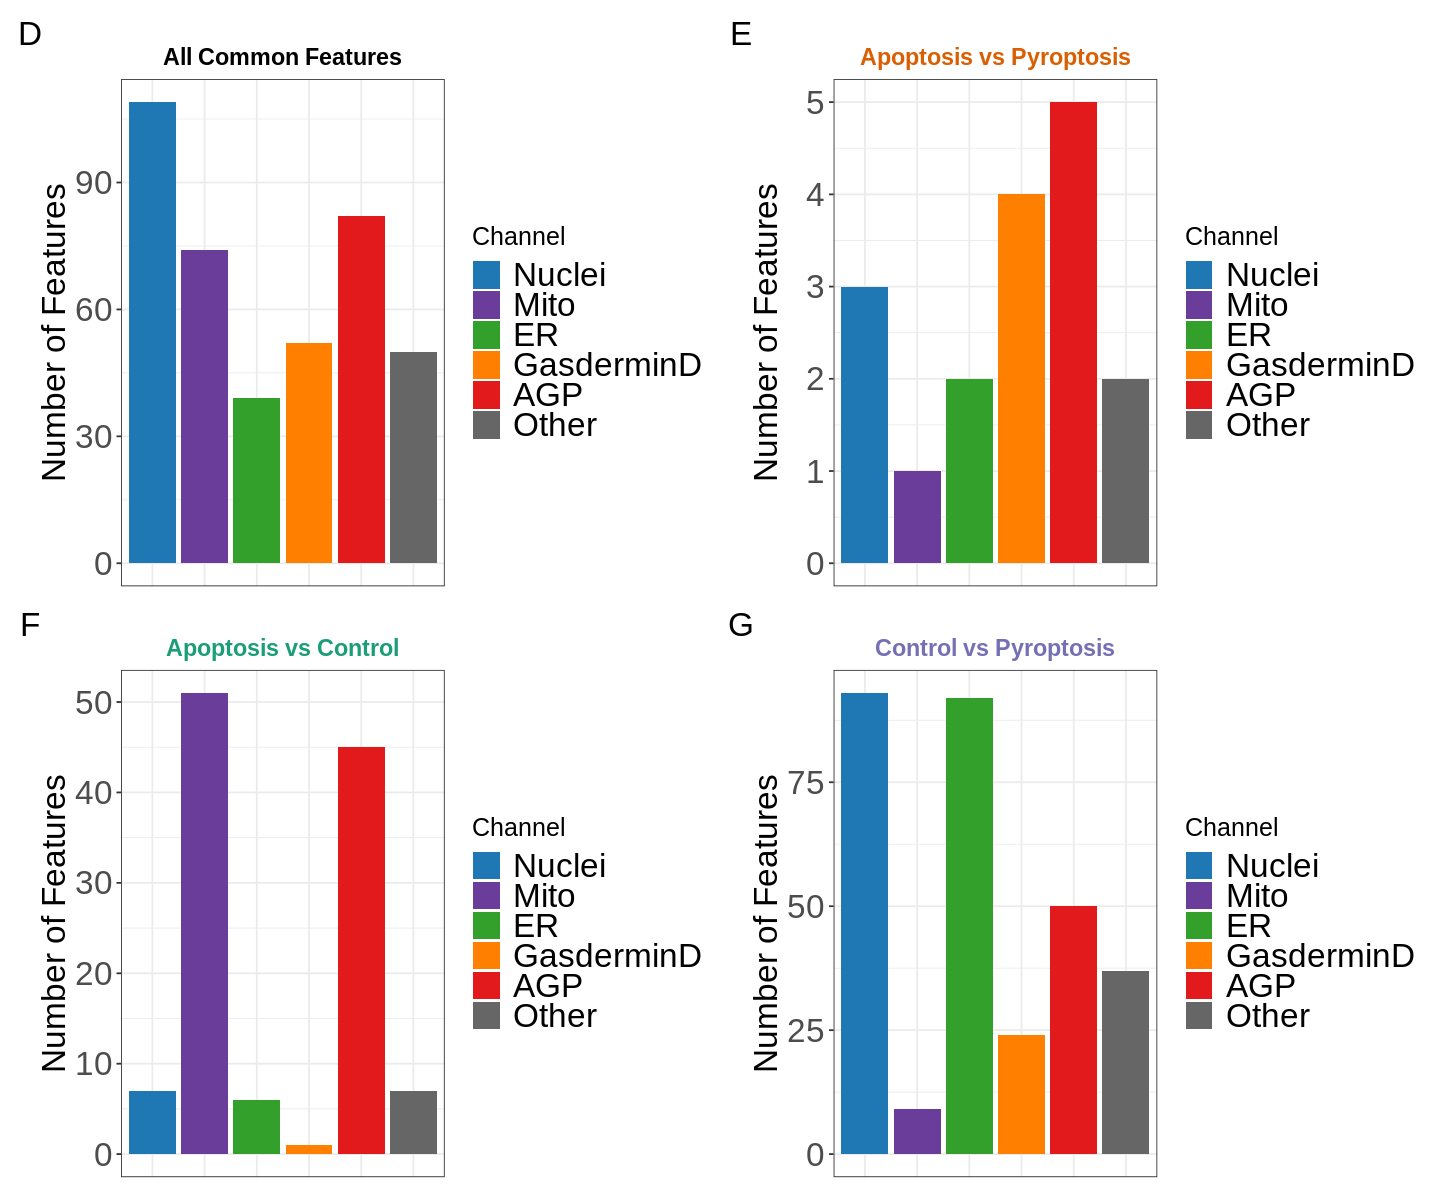

In [82]:
# patch work plot of the venn diagram and bar plots


layout <- c(
    area(t=1, b=2, l=1, r=2), 
    area(t=1, b=2, l=3, r=4), 
    area(t=3, b=4, l=1, r=2), 
    area(t=3, b=4, l=3, r=4)
)

# set plot size
width <- 12
height <- 10
options(repr.plot.width=width, repr.plot.height=height)
sub_figure3 <- (
    a_h__a_p__h_p_common_plot
    + a_p_unique_plot
    + a_h_unique_plot
    
    + h_p_unique_plot
    + plot_layout(design = layout)
    + plot_annotation(tag_levels = list(c( "D", "E", "F", "G"))) & theme(plot.tag = element_text(size = 20))

)
sub_figure3


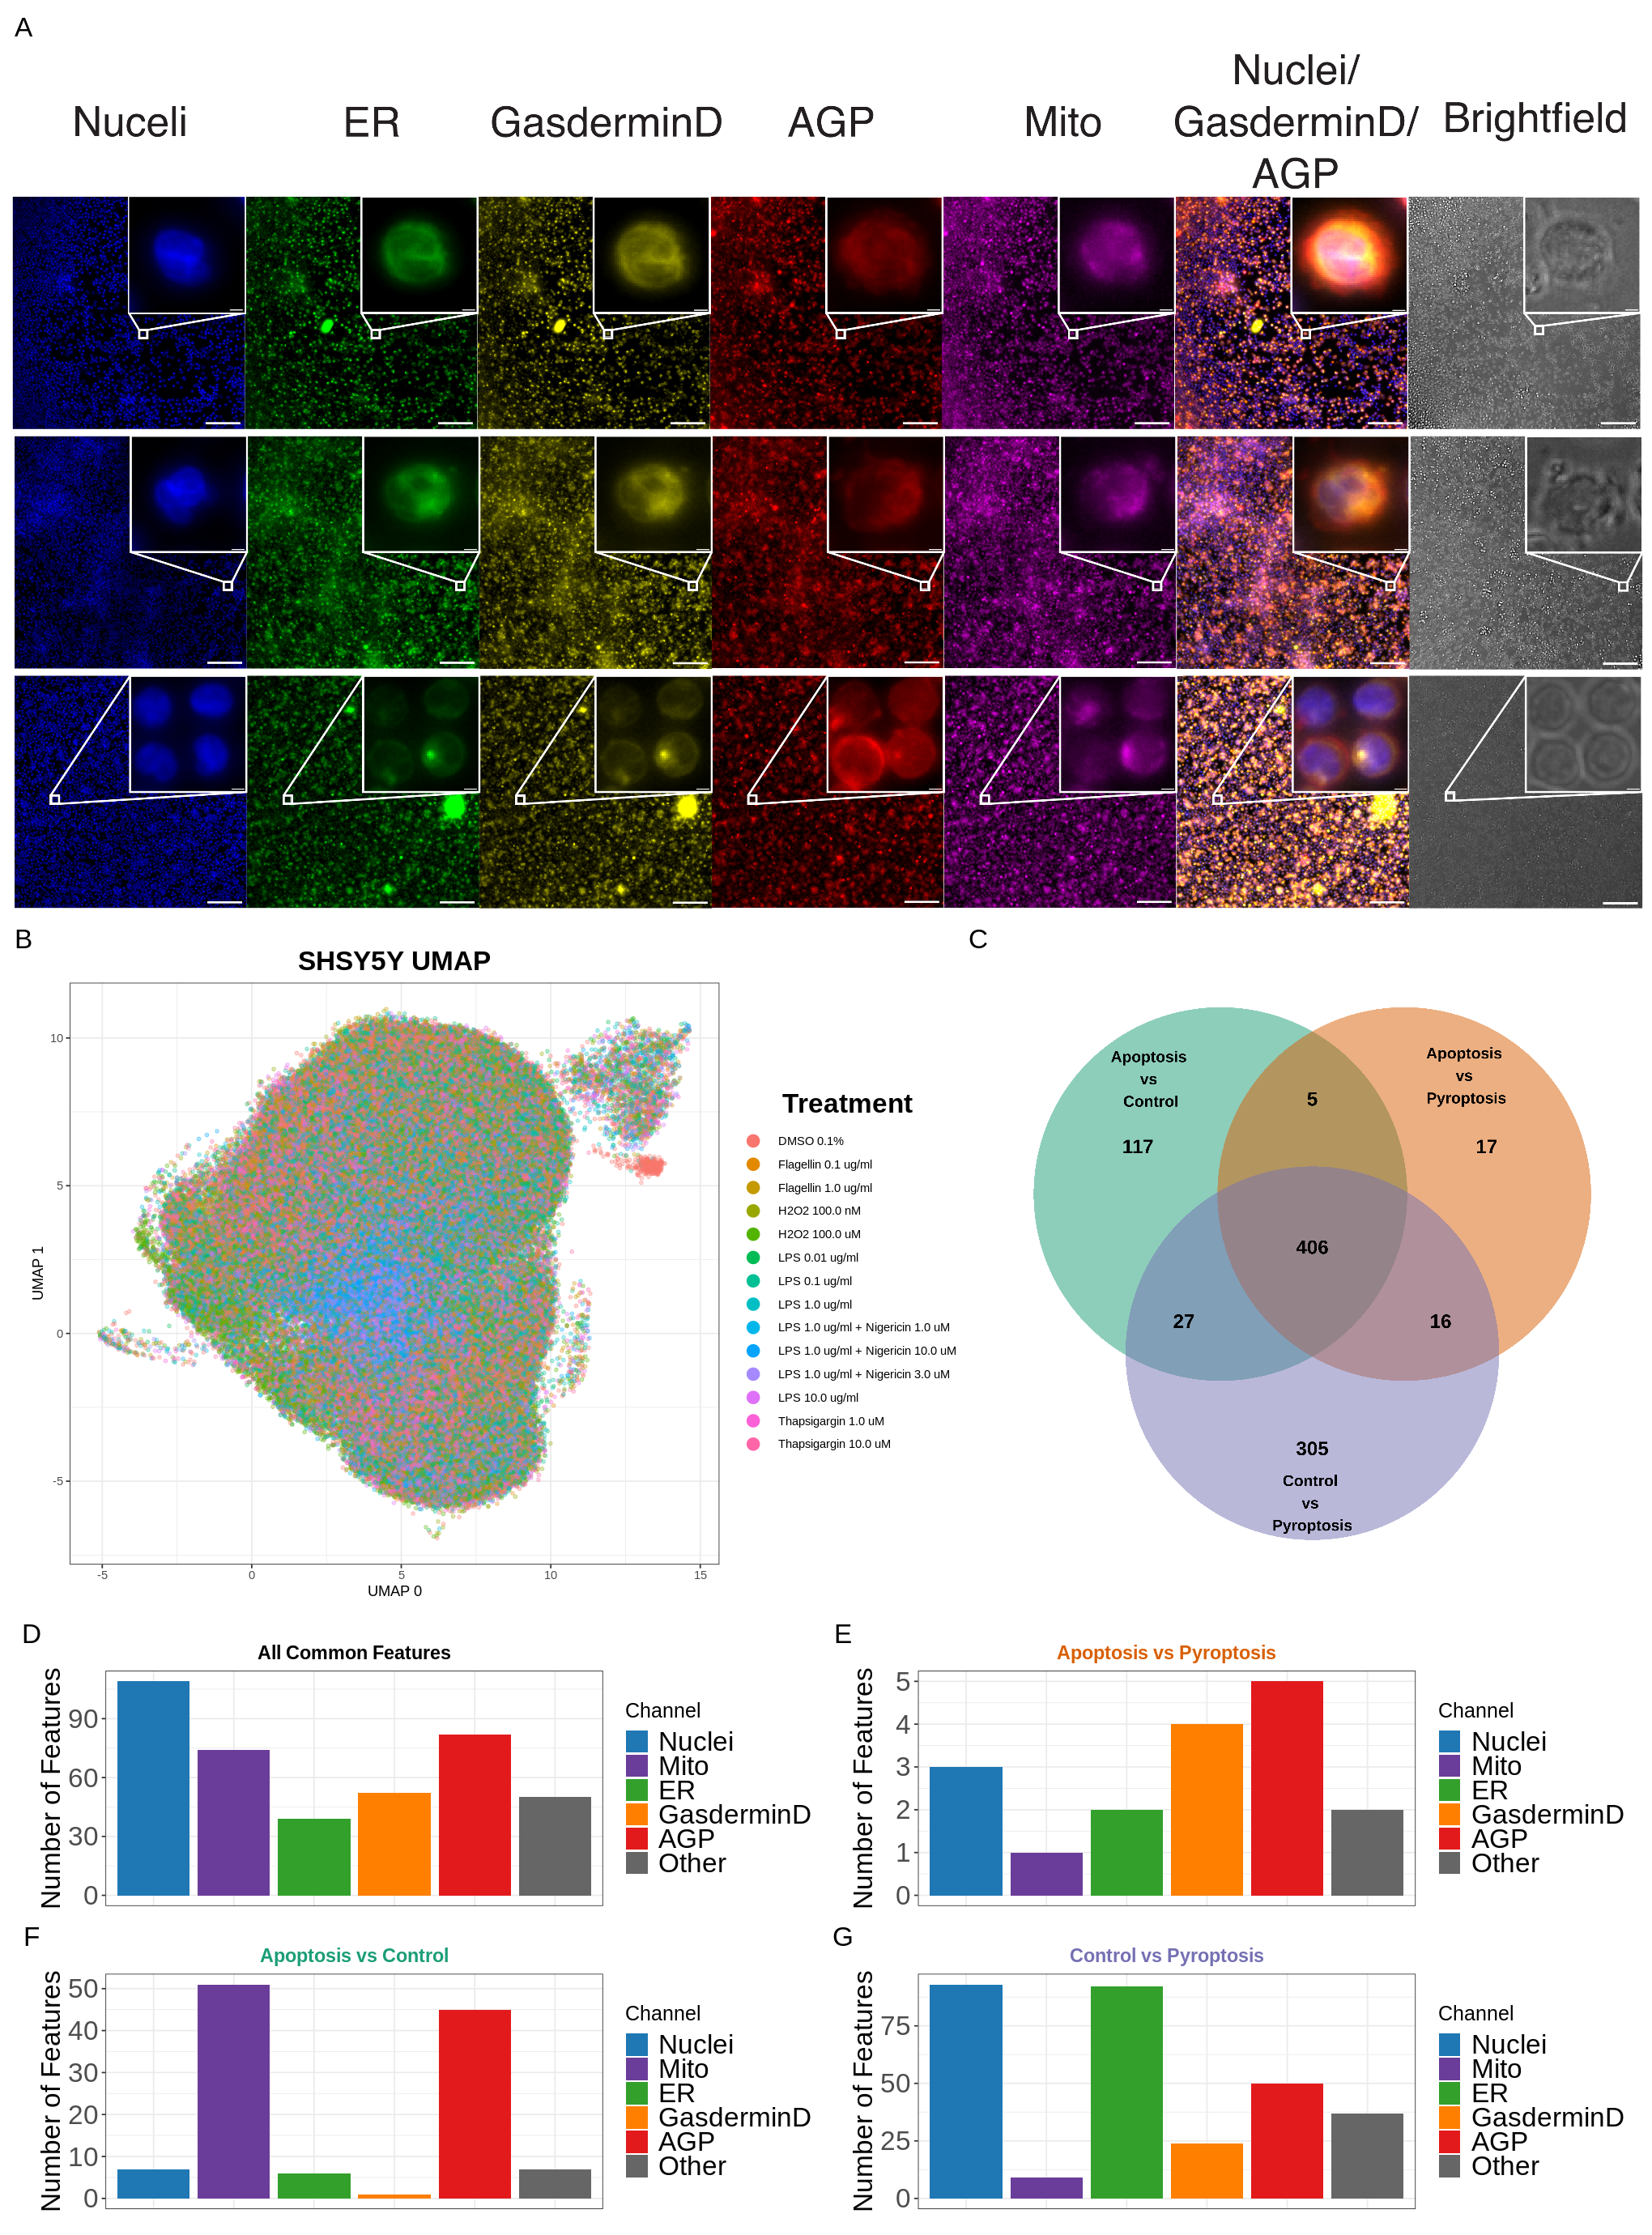

In [83]:
layout <- c(
    area(t=1, b=3, l=1, r=4), 
    area(t=4, b=5, l=1, r=2),
    area(t=4, b=5, l=3, r=4),
    area(t=6, b=7, l=1, r=4)
)

# patch work the plots together
# set plot size
width <- 17
height <- 23
options(repr.plot.width=width, repr.plot.height=height, units = "cm", dpi = 600)

fig3 <- (
    wrap_elements(full = montage)
    # montage
    + umap_plot_selected
    + venn_diagram_image
    + wrap_elements(full = sub_figure3)
    # + sub_figure3
    + plot_layout(design = layout, widths = c(8,8 ))
    # make bottom plot not align
    + plot_annotation(tag_levels = list(c("A", "B", "C"))) & theme(plot.tag = element_text(size = 20))

)
ggsave(
    filename = file.path("figures",paste0(cell_type,"_figure3.png")),
    plot = fig3,
    width = width,
    height = height,
    units = "in",
    dpi = 600
)

fig3


In [84]:
sessionInfo()


R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Pop!_OS 22.04 LTS

Matrix products: default
BLAS/LAPACK: /home/lippincm/miniconda3/envs/Interstellar/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggvenn_0.1.10         lubridate_1.9.3       forcats_1.0.0        
 [4] readr_2.1.4           tidyr_1.3.0           tibble_3.2.1         
 [7] tidyverse_2.0.0       VennDiagram_1.7.3     futile.logger_1.4.3  
[10] purrr_1.0.1           stringr_1.5.0         reshape2_1.4.4       